# Section 3: Panel data & pseudo-experiments

### Housekeeping and Data

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
import linearmodels.panel as lmp
import pytwoway as tw
import bipartitepandas as bpd
import seaborn as sns
from linearmodels.iv import IV2SLS

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

We use data from the ENIA panel survey. Variable description follows:  

- *ID*: firm unique identifier  
- *year*: survey year  
- *tamano*: 1 large, 2 medium, 3 small, 4 micro (funcion de las ventas y el numero de trabajadores)  
- *sales*: sales (in log of 1,000 CLP)  
- *age*: firm age at time of survey  
- *foreign*: non-domestic firm (binary)  
- *export*: production for export (binary)  
- *workers*: log of number of workers  
- *fomento*: firm receives public incentives (binary)  
- *iyd*: firm does I+D (binary)  
- *impuestos*: taxes (in million US)  
- *utilidades*: firm revenue (in million US)  


In [73]:
# example data
enia=pd.read_csv('../data/enia.csv')
enia.dropna(inplace=True)
enia.export = enia.export.astype(int)
Xa = enia
bycount = enia['year'].groupby(enia['year']).count()
bIDcount = enia['ID'].groupby(enia['ID']).count()
enia['yr'] = enia['year'].astype(object)
enia = pd.get_dummies(enia)
enia = enia.set_index(["ID","year"])
enia['utilidades']=np.log(enia['utilidades']-enia['utilidades'].min()+0.1)
enia = enia[enia["utilidades"] < 10000]
enia.describe()

,tamano,sales,age,foreign,export,workers,fomento,iyd,impuestos,utilidades
count,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000
mean,2.248773,3.574172,15.305084,0.081859,0.111191,1.757726,0.076105,0.224887,0.203856,5.500845
std,1.153089,1.692742,12.488330,0.274153,0.314372,1.186507,0.265169,0.417514,15.869466,0.060706
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-180.992528,-2.302585
25%,1.000000,2.337643,7.000000,0.000000,0.000000,0.778151,0.000000,0.000000,0.000000,5.499092
50%,2.000000,3.553321,14.000000,0.000000,0.000000,1.785330,0.000000,0.000000,0.000007,5.499092
75%,3.000000,4.539098,20.000000,0.000000,0.000000,2.661813,0.000000,0.000000,0.000167,5.499097
max,4.000000,10.309005,190.000000,1.000000,1.000000,5.845915,1.000000,1.000000,2981.494528,10.729529


## Pooled OLS

In [74]:
#Minimo cuadrado agrupado
y=enia['workers']
X=enia[['sales','age','foreign','export','iyd','utilidades','yr_2009','yr_2013','yr_2015','yr_2017']]
X=sm.add_constant(X)
model = lmp.PanelOLS(y, X)
mco = model.fit()
print(mco)

                          PanelOLS Estimation Summary                           
Dep. Variable:                workers   R-squared:                        0.6173
Estimator:                   PanelOLS   R-squared (Between):              0.6323
No. Observations:               39104   R-squared (Within):               0.4109
Date:                Mon, May 06 2024   R-squared (Overall):              0.6173
Time:                        12:00:21   Log-likelihood                -4.339e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6306.1
Entities:                       24128   P-value                           0.0000
Avg Obs:                       1.6207   Distribution:                F(10,39093)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             6306.1
                            

## First differences

In [75]:
X=enia[['sales','age','foreign','export','iyd','utilidades','yr_2009','yr_2013','yr_2015','yr_2017']]
model=lmp.FirstDifferenceOLS(y,X)
fd=model.fit(cov_type="robust")
print(fd)

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:                workers   R-squared:                        0.4409
Estimator:         FirstDifferenceOLS   R-squared (Between):              0.7419
No. Observations:               14188   R-squared (Within):               0.5529
Date:                Mon, May 06 2024   R-squared (Overall):              0.7419
Time:                        12:00:22   Log-likelihood                -1.194e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1117.9
Entities:                       24128   P-value                           0.0000
Avg Obs:                       1.6207   Distribution:                F(10,14178)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             794.92
                            

## Fixed Effects 

In [76]:
X=sm.add_constant(X)
model=lmp.PanelOLS(y,X, entity_effects=True)
fe=model.fit(cov_type="robust")
print(fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                workers   R-squared:                        0.5559
Estimator:                   PanelOLS   R-squared (Between):              0.4194
No. Observations:               39104   R-squared (Within):               0.5559
Date:                Mon, May 06 2024   R-squared (Overall):              0.4233
Time:                        12:00:22   Log-likelihood                   -3479.8
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1873.0
Entities:                       24128   P-value                           0.0000
Avg Obs:                       1.6207   Distribution:                F(10,14966)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             892.28
                            

## Random Effects


In [77]:
model=lmp.RandomEffects(y,X)
re=model.fit(cov_type="robust")
print(re)

                        RandomEffects Estimation Summary                        
Dep. Variable:                workers   R-squared:                        0.5343
Estimator:              RandomEffects   R-squared (Between):              0.6196
No. Observations:               39104   R-squared (Within):               0.4798
Date:                Mon, May 06 2024   R-squared (Overall):              0.6036
Time:                        12:00:22   Log-likelihood                -2.422e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4485.9
Entities:                       24128   P-value                           0.0000
Avg Obs:                       1.6207   Distribution:                F(10,39093)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             4874.1
                            

In [78]:
re.variance_decomposition

Effects                   0.314164
Residual                  0.182783
Percent due to Effects    0.632189
Name: Variance Decomposition, dtype: float64

## Model comparison

In [79]:
print(lmp.compare({"FE": fe, "RE": re, "Pooled": mco}))

                           Model Comparison                           
                                   FE                RE         Pooled
----------------------------------------------------------------------
Dep. Variable                 workers           workers        workers
Estimator                    PanelOLS     RandomEffects       PanelOLS
No. Observations                39104             39104          39104
Cov. Est.                      Robust            Robust     Unadjusted
R-squared                      0.5559            0.5343         0.6173
R-Squared (Within)             0.5559            0.4798         0.4109
R-Squared (Between)            0.4194            0.6196         0.6323
R-Squared (Overall)            0.4233            0.6036         0.6173
F-statistic                    1873.0            4485.9         6306.1
P-value (F-stat)               0.0000            0.0000         0.0000
=====================     ===========   ===============   ============
const 

Hausman Test

In [80]:
import numpy.linalg as la
from scipy import stats

def hausman(fe, re):
 diff = fe.params-re.params
 psi = fe.cov - re.cov
 dof = diff.size -1
 W = diff.dot(la.inv(psi)).dot(diff)
 pval = stats.chi2.sf(W, dof)
 return W, dof, pval

htest = hausman(fe, re) 
print("Hausman Test: chi-2 = {0}, df = {1}, p-value = {2}".format(htest[0], htest[1], htest[2]))

Hausman Test: chi-2 = 816.8930431511317, df = 10, p-value = 4.814183310169493e-169


## Correlated Random Effects

In [81]:
X = enia.drop(['workers','tamano','fomento','yr_2009','yr_2013','yr_2015','yr_2017'], axis=1, inplace=False)
Xm = X.groupby(by = 'ID').transform('mean')
Xm.columns = ['m{}'.format(column) for column in Xm.columns]
Xc = pd.merge(enia,Xm, left_index=True, right_index=True)
Y = Xc['workers']
X = Xc[['sales','age','foreign','export','iyd','utilidades','msales','mage','mexport','miyd','mutilidades','yr_2009','yr_2013','yr_2015','yr_2017']]
X=sm.add_constant(X)

model=lmp.RandomEffects(y,X)
cre=model.fit(cov_type="robust")
print(cre)

                        RandomEffects Estimation Summary                        
Dep. Variable:                workers   R-squared:                        0.5622
Estimator:              RandomEffects   R-squared (Between):              0.6252
No. Observations:               39104   R-squared (Within):               0.5420
Date:                Mon, May 06 2024   R-squared (Overall):              0.6229
Time:                        12:00:23   Log-likelihood                -2.301e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3345.9
Entities:                       24128   P-value                           0.0000
Avg Obs:                       1.6207   Distribution:                F(15,39088)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             4340.1
                            

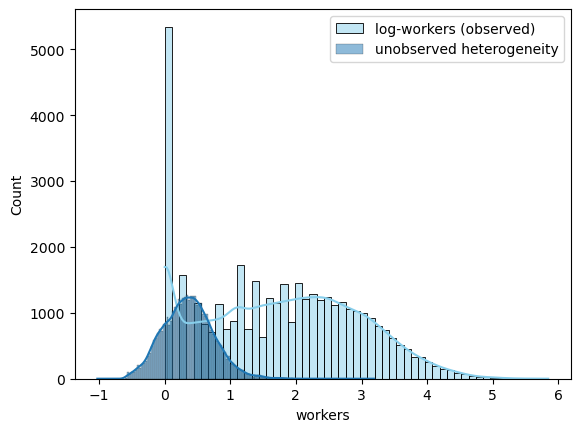

In [82]:
Xpred = X
Xpred['sales']=0
Xpred['age']=0
Xpred['export']=0
Xpred['iyd']=0
Xpred['utilidades']=0
Xpred['foreign']=0
Xpred['yr_2009']=0
Xpred['yr_2013']=0
Xpred['yr_2015']=0
Xpred['yr_2017']=0
yhat = cre.predict(Xpred)

sns.histplot(data=y, color="skyblue", label="log-workers (observed)", kde=True)
sns.histplot(data=yhat, color="red", label="unobserved heterogeneity", kde=True)

plt.legend() 
plt.show()

In [83]:
print(lmp.compare({"FE": fe, "RE": re, "CRE": cre}))

                             Model Comparison                            
                                   FE                RE               CRE
-------------------------------------------------------------------------
Dep. Variable                 workers           workers           workers
Estimator                    PanelOLS     RandomEffects     RandomEffects
No. Observations                39104             39104             39104
Cov. Est.                      Robust            Robust            Robust
R-squared                      0.5559            0.5343            0.5622
R-Squared (Within)             0.5559            0.4798            0.5420
R-Squared (Between)            0.4194            0.6196            0.6252
R-Squared (Overall)            0.4233            0.6036            0.6229
F-statistic                    1873.0            4485.9            3345.9
P-value (F-stat)               0.0000            0.0000            0.0000
=====================     =========== 

### Instrumental Variables

*I&D* es una variable endogena, y podemos considerar a *fomento* y *age* como instrumentos (exogenos) para poder estimar correctamente el efecto de la investigacion y desarrollo sobre el numero de trabajadores (modelo estatico sin considerar efectos temporales).

In [84]:
from statsmodels.api import add_constant
enia = sm.add_constant(enia)
res_ols = IV2SLS(enia.workers, enia[['sales','foreign','export','utilidades','iyd','const']], None, None).fit(
    cov_type="unadjusted")
res_IV = IV2SLS(enia.workers, enia[['sales','foreign','export','utilidades','const']], enia['iyd'], enia[['fomento','age']]).fit(
    cov_type="unadjusted")

from linearmodels.iv import compare
print(compare({"OLS": res_ols, "2SLS": res_IV}))

                 Model Comparison                 
                                OLS           2SLS
--------------------------------------------------
Dep. Variable               workers        workers
Estimator                       OLS        IV-2SLS
No. Observations              39104          39104
Cov. Est.                unadjusted     unadjusted
R-squared                    0.2132         0.0800
Adj. R-squared               0.2131         0.0799
F-statistic                1.06e+04         8729.8
P-value (F-stat)             0.0000         0.0000
==================     ============   ============
sales                        0.2529         0.2408
                           (77.191)       (65.328)
foreign                      0.4031         0.3700
                           (19.791)       (16.668)
export                       0.4124         0.2006
                           (22.856)       (7.6043)
utilidades                  -0.5363        -0.6523
                          (-6.0

#### Instrumental variables with panel data

Primero replicar resultados de arriba pero en modelo de panel (comparar resultados con modelo FE). La libreria tambien permite realizar test de identificacion y exogeneidad (pero presenta problemas computacionales, por eso se aplica en una muestra restringida).

In [85]:
from fixedeffect.iv import iv2sls, ivgmm, ivtest
Xa.loc[Xa["year"] > 2012, "year"] = Xa["year"] - 2
Xa['year'] = (Xa['year'] - 2005)/2
Xa = Xa.loc[Xa["ID"] < 200000,] 
Xa.describe()

,ID,year,tamano,sales,age,foreign,export,workers,fomento,iyd,impuestos,utilidades
count,25328.000000,25328.000000,25328.000000,25328.000000,25328.000000,25328.000000,25328.000000,25328.000000,25328.000000,25328.000000,25328.000000,2.532800e+04
mean,133179.169259,2.152993,2.359484,3.762184,15.465256,0.076358,0.106483,1.537945,0.092388,0.237642,0.314562,2.896482e+00
std,44225.531697,1.239448,1.157920,1.933458,12.912701,0.265576,0.308461,1.174144,0.289578,0.425647,19.717691,2.866379e+02
min,100000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-180.992528,-2.443698e+02
25%,103250.000000,1.000000,1.000000,2.274441,7.000000,0.000000,0.000000,0.602060,0.000000,0.000000,0.000000,7.197500e-08
50%,107235.500000,2.000000,2.000000,3.665193,14.000000,0.000000,0.000000,1.380211,0.000000,0.000000,0.000005,8.880000e-05
75%,200660.250000,3.000000,3.000000,5.182868,20.000000,0.000000,0.000000,2.392697,0.000000,0.000000,0.000326,5.034424e-03
max,204399.000000,5.000000,4.000000,10.309005,190.000000,1.000000,1.000000,5.814677,1.000000,1.000000,2981.494528,4.544069e+04


In [92]:
formula = 'workers ~ sales + foreign + export + utilidades + iyd|ID+year|ID+year|0'

model_fe = fixedeffect(data_df = Xa,
                       formula = formula,
                       no_print=True)
result = model_fe.fit()
print(result.params)
print(result.bse)

const         1.209717
sales         0.081553
foreign       0.108999
export        0.028028
utilidades    0.000017
iyd           0.042300
dtype: float64
const         0.031051
sales         0.007607
foreign       0.048345
export        0.024935
utilidades    0.000002
iyd           0.007133
Name: bse, dtype: float64


In [94]:
formula = 'workers ~ sales + foreign + export + utilidades|ID+year|0|(iyd~fomento + age)'
model_iv2sls = iv2sls(data_df = Xa,
                      formula = formula)
result = model_iv2sls.fit()
print(result.params)
print(result.bse)

dependent variable(s): ['workers']
independent(exogenous): ['sales', 'foreign', 'export', 'utilidades']
category variables(fixed effects): ['ID', 'year']
cluster variables: ['0']
endogenous variables: ['iyd']
instruments: ['fomento', 'age']
const         1.249024
sales         0.082538
foreign       0.100414
export        0.031528
utilidades    0.000018
hat_iyd      -0.137505
dtype: float64
const         0.050952
sales         0.006129
foreign       0.028662
export        0.020474
utilidades    0.000012
hat_iyd       0.208132
dtype: float64


In [95]:
ivtest(result)

Weak IV test with critical values based on 2SLS size
  Cragg-Donald Statistics:            39.868516  
  number of instrumental variables:           2  
  number of endogenous variables:             1  
                                      5%        10%        20%        30%    
-----------------------------------------------------------------------------
2SLS Size of nominal 5% Wald test    19.9300    11.5900     8.7500     7.2500
-----------------------------------------------------------------------------
H0: Instruments are weak

     Over identification test - nonrobust     
                    test statistics  p values 
----------------------------------------------
Sargan Statistics:           9.8898     0.0195
Basmann Statistics:          3.2970     0.3481
----------------------------------------------

             Tests of endogeneity            
                   test statistics  p values 
---------------------------------------------
Durbin Statistics:          1.7721    

<font size="3">**Tarea 2**</font>

<u> *Instrucciones* </u>

Los resultados de los ejericicios propuestos se deben entregar como un notebook por correo electronico a *juancaros@udec.cl* el dia 24/5 hasta las 21:00. 

Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. El repositorio de datos se encuentra en https://observa.minciencia.gob.cl/datos-abiertos/datos-del-repositorio-covid-19 

Los conjuntos de datos permiten identificar las etapas de las cuarentenas (paso a paso, producto 74), calidad del aire (producto 43) y otras informaciones relacionadas con los la evolucion de la epidemia COVID-19. 

Preguntas:

1. Crear un set de datos de frecuencia mensual que permita estudiar el efecto de las cuarentenas dinamicas (paso a paso) sobre la calidad del aire en las comunas que poseen estaciones de medicion durante 2021. Queda a discrecion como agregar y generar el set de datos final para estimacion.


2. Ejecute un modelo Pooled OLS para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado.


3. Ejecute un modelo efectos fijos para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado.


4. Ejecute un modelo de efectos aleatorios para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. 


5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?


6. Ejecute un modelo de efectos aleatorios correlacionados (CRE) para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. Es este modelo adecuado, dada la data disponible, para modelar el componente no observado?


7. Usando el modelo CRE, prediga la distribucion del componente no observado. Que puede inferir respecto de la heterogeneidad fija en el tiempo y su impacto en la calidad del aire?

8. Usando sus respuestas anteriores, que modelo prefiere? que se puede inferir en general respecto del efecto de las variables explicativas sobre el numero de trabajadores?


9. Es posible que sus resultados anteriores tengan sesgo dado que las cuarentenas (paso a paso) son endogenas al comportamiento de las personas. Construya AL MENOS DOS instrumentos posibles para las cuarentenas dinamicas, de forma que se pueda corregir el sesgo y entender el efecto causal de las cuarentenas en el aire. Realice su estimacion considerando un modelo agrupado (ignorando el tiempo), y el modelo de panel.